<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.dummy import DummyRegressor

In [2]:
train = pd.read_csv('/datasets/gold_industry_train.csv')
test = pd.read_csv('/datasets/gold_industry_test.csv')
full = pd.read_csv('/datasets/gold_industry_full.csv')

In [3]:
print(train.shape, test.shape, full.shape)

(14579, 87) (4860, 53) (19439, 87)


In [4]:
def review(data):
    print(data.head())
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    print(data.info())
    print('Количество дубликатов', data.duplicated().sum())
    for column in data.columns:
        data[column].fillna(method='ffill', inplace=True)
    print('Количество пропусков', data.isna().sum().sum())
    print()

In [5]:
for data in [train, test, full]:
    review(data)

                  date  rougher.input.feed_au  rougher.input.feed_ag  \
0  2016-01-15 00:00:00               6.486150               6.100378   
1  2016-01-15 01:00:00               6.478583               6.161113   
2  2016-01-15 02:00:00               6.362222               6.116455   
3  2016-01-15 03:00:00               6.118189               6.043309   
4  2016-01-15 04:00:00               5.663707               6.060915   

   rougher.input.feed_pb  rougher.input.feed_sol  rougher.input.feed_rate  \
0               2.284912               36.808594               523.546326   
1               2.266033               35.753385               525.290581   
2               2.159622               35.971630               530.026610   
3               2.037807               36.862241               542.590390   
4               1.786875               34.347666               540.531893   

   rougher.input.feed_size  rougher.input.floatbank10_sulfate  \
0                55.486599             

Дубликатов в данных нет, было много пропусков в данных, я их всех заменила методом ffill, а также я заменила тип данных для столбца date с object на datetime

In [6]:
c = train['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки
f = train['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки
t = train['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки

In [7]:
recovery = c*(f-t) / (f*(c-t)) * 100

In [8]:
mae_rougher =  mean_absolute_error(train['rougher.output.recovery'], recovery)
mae_rougher

9.83758577644259e-15

Эффективность обогащения рассчитана правильно.

In [9]:
lst = []
for column in train.columns:
    if column not in test.columns:
        lst.append(column)
lst

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

Недоступны параметры продукта концентрата, а также отвальные хвосты на всех этапах и расчётные характеристики.

In [10]:
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']], how='inner', on= 'date')

Добавила недостающие столбцы в тестовую выборку

## Анализ данных

In [11]:
feed = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']
rougher = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']
primary = ['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 
           'primary_cleaner.output.concentrate_pb']
final = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

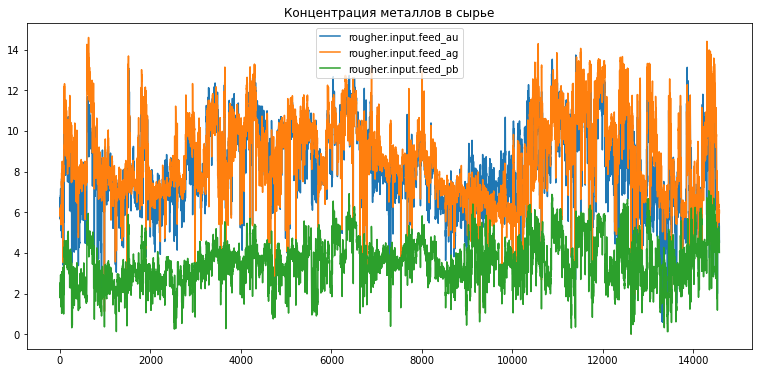

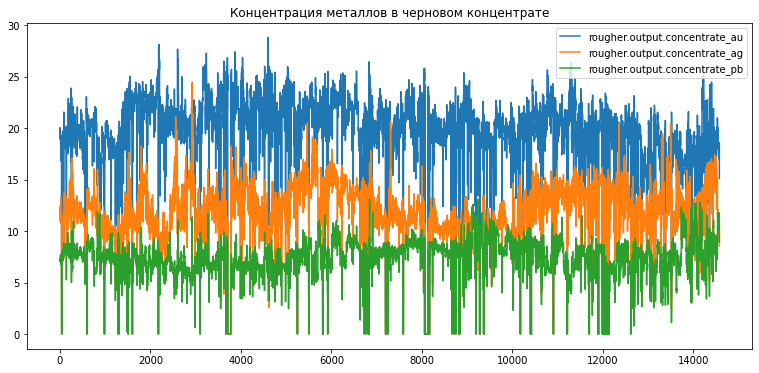

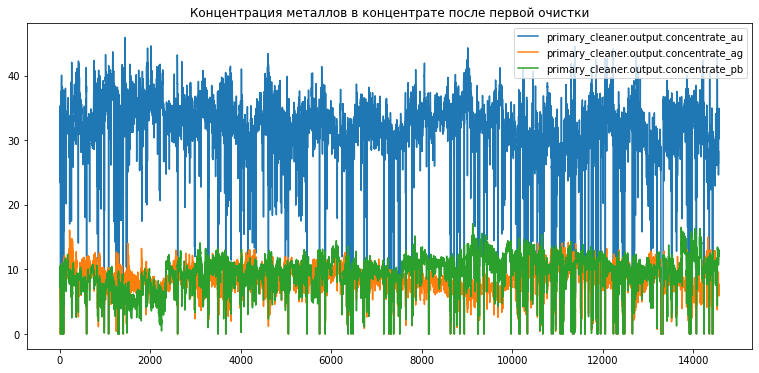

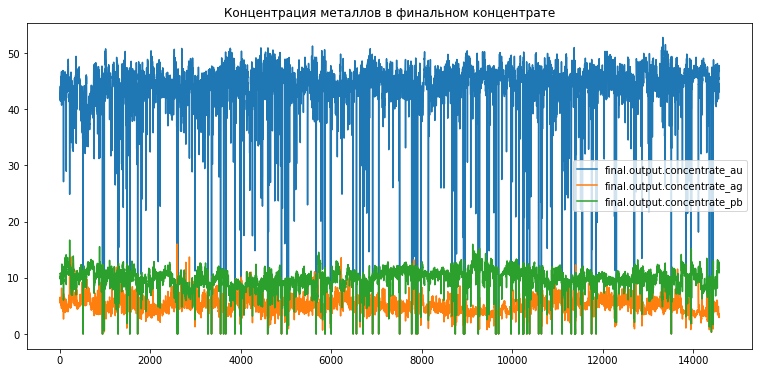

In [12]:
train[feed].plot(figsize=(13,6), title='Концентрация металлов в сырье');
train[rougher].plot(figsize=(13,6), title='Концентрация металлов в черновом концентрате');
train[primary].plot(figsize=(13,6), title='Концентрация металлов в концентрате после первой очистки');
train[final].plot(figsize=(13,6), title='Концентрация металлов в финальном концентрате');

In [13]:
print('Промежутки концентрации металлов на различных этапах')
df = pd.DataFrame(index=['Сырье', 'Черновой концентрат', 'Первая очистка', 'Финальный концентрат'], 
                  columns=['Au', 'Ag', 'Pb'])
df.loc['Сырье', :] = ['5-12', '6-14', '1-6']
df.loc['Черновой концентрат', :] = ['12-25', '7-17', '5-10']
df.loc['Первая очистка', :] = ['20-40', '5-12', '4-14']
df.loc['Финальный концентрат', :] = ['35-50', '3-9', '8-12']
df

Промежутки концентрации металлов на различных этапах


,Au,Ag,Pb
Сырье,5-12,6-14,1-6
Черновой концентрат,12-25,7-17,5-10
Первая очистка,20-40,5-12,4-14
Финальный концентрат,35-50,3-9,8-12


Прослеживается увеличение концентрации золота, серебра после всех этапов становится меньше, а свинец показывает незначительное увеличение.

In [14]:
train['rougher.input.feed_size'].mean()

59.07086496192819

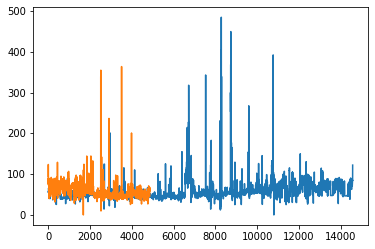

In [15]:
train['rougher.input.feed_size'].plot();
test['rougher.input.feed_size'].plot();

In [16]:
test['rougher.input.feed_size'].mean()

59.13615007330843

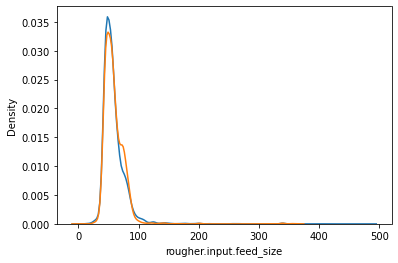

In [17]:
sns.kdeplot(train['rougher.input.feed_size'], common_norm=True);
sns.kdeplot(test['rougher.input.feed_size'], common_norm=True);

Распределение размеров гранул отличаются всего лишь на 0,06, значит, оценка модели будет верной

In [18]:
full['rougher.input.feed_sum'] = full['rougher.input.feed_au'] + full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_sol']
full['rougher.output.concentrate_sum'] = full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol']
full['primary_cleaner.output.concentrate_sum'] = full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol']
full['final.output.concentrate_sum'] = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_sol']

Суммарная концентрация золота и свинца увеличивается, а серебра наоборот - уменьшается. Это все кажется странным, так как после каждого этапа металла должно становиться меньше

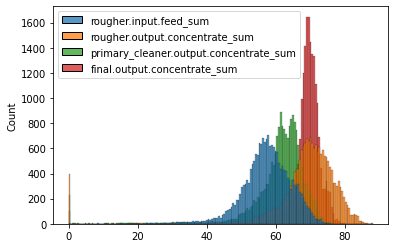

In [19]:
sns.histplot(full[['rougher.input.feed_sum', 'rougher.output.concentrate_sum', 
                    'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']]);

In [20]:
for col in ['rougher.input.feed_sum', 'rougher.output.concentrate_sum', 'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']:
    full = full[full[col] > 0]
                
train = train.set_index('date')
full = full.set_index('date')
train = train.loc[train.index.isin(full.index)]

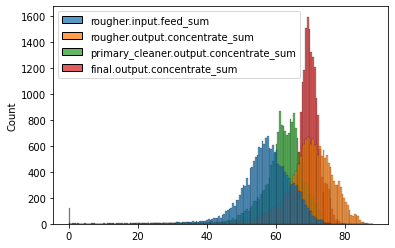

In [21]:
sns.histplot(full[['rougher.input.feed_sum', 'rougher.output.concentrate_sum', 
                    'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']]);

## Модель

In [22]:
def smape(target, predict):
    result = 0
    result = (abs(target - predict)/(abs(target) + abs(predict))).sum()
    return 2 * result / len(target) * 100

In [23]:
def final_smape(sMAPE_rougher, sMAPE_final):
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

In [24]:
target_rougher = train['rougher.output.recovery']
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_train = train.drop(lst, axis=1)
target_final = train['final.output.recovery']

In [25]:
scorer = make_scorer(smape, greater_is_better=False)
model = LinearRegression()
grid = GridSearchCV(model, param_grid={}, scoring=scorer, cv=5)
grid.fit(features_train, target_rougher)
best_grid_rougher_lr = grid.best_score_ * (-1)
grid.fit(features_train, target_final)
best_grid_final_lr = grid.best_score_ * (-1)
print('best_grid_rougher', best_grid_rougher_lr)
print('best_grid_final', best_grid_final_lr)

best_grid_rougher 7.039186251866072
best_grid_final 9.477923458692736


In [26]:
print('final sMAPE', final_smape(best_grid_rougher_lr, best_grid_final_lr))

final sMAPE 8.86823915698607


In [27]:
model = DecisionTreeRegressor()
grid = GridSearchCV(model, param_grid={'max_depth': range(1, 20)}, scoring=scorer, cv=5)
grid.fit(features_train, target_rougher)
best_grid_rougher_tree = grid.best_score_ * (-1)
grid.fit(features_train, target_final)
best_grid_final_tree = grid.best_score_ * (-1)
print('best_grid_rougher', best_grid_rougher_tree)
print('best_grid_final', best_grid_final_tree)

best_grid_rougher 6.725187983897763
best_grid_final 9.15152451351102


In [28]:
print('final sMAPE', final_smape(best_grid_rougher_tree, best_grid_final_tree))

final sMAPE 8.544940381107706


In [29]:
%%time
# 16 минут 
model = RandomForestRegressor()
grid = GridSearchCV(model, param_grid={'max_depth': range(1, 10), 'n_estimators': range(10, 31, 10)}, scoring=scorer, cv=5)
grid.fit(features_train, target_rougher)
best_grid_rougher_forest = grid.best_score_ * (-1)
grid.fit(features_train, target_final)
best_grid_final_forest = grid.best_score_ * (-1)
print('best_grid_rougher', best_grid_rougher_forest)
print('best_grid_final', best_grid_final_forest)

best_grid_rougher 6.43860380836809
best_grid_final 8.832049996382782
CPU times: user 14min 13s, sys: 1.28 s, total: 14min 15s
Wall time: 14min 15s


In [30]:
print('final sMAPE', final_smape(best_grid_rougher_forest, best_grid_final_forest))

final sMAPE 8.233688449379109


In [31]:
target_rougher_test = test['rougher.output.recovery']
features_test = test.drop(['rougher.output.recovery', 'date', 'final.output.recovery'], axis=1)
target_final_test = test['final.output.recovery']

In [32]:
model = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'],
                              max_depth=grid.best_params_['max_depth'], random_state=12345)
model.fit(features_train, target_rougher)
predict_test_rougher = model.predict(features_test)
model.fit(features_train, target_final)
predict_test_final = model.predict(features_test)
print('sMAPE', smape(target_rougher_test, predict_test_rougher), smape(target_final_test, predict_test_final))

sMAPE 4.844032291516639 8.40392987794827


In [33]:
print('final sMAPE', final_smape(smape(target_rougher_test, predict_test_rougher), 
                                 smape(target_final_test, predict_test_final)))

final sMAPE 7.513955481340362


In [34]:
dummy_regr = DummyRegressor(strategy="median")
grid_dummy = GridSearchCV(dummy_regr, param_grid={}, scoring=scorer, cv=5)
grid_dummy.fit(features_train, target_rougher)
predict_rougher = grid_dummy.predict(features_test)
grid_dummy.fit(features_train, target_final)
predict_final = grid_dummy.predict(features_test)
print('sMAPE', smape(target_rougher_test, predict_rougher), smape(target_final_test, predict_final))
print('final sMAPE', final_smape(smape(target_rougher_test, predict_rougher), smape(target_final_test, predict_final)))

sMAPE 5.835969960413102 9.11454843929903
final sMAPE 8.294903819577549


***Вывод***:

Моя задача состояла в том, чтобы подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Я использовала данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Я проанализировала и обработала данные. Посмотрела как меняется суммарная концентрация металлов: прослеживается увеличение концентрации золота, серебра после всех этапов становится меньше, а свинец показывает незначительное увеличение.

Я обучила разные модели и оценила их качество кросс-валидацией и пришла к выводу, что лучшей моделью является модель леса, для которой итоговая sMAPE = 8.24. На тестовой выборке я получила результат 7.54.